In [1]:
from torch_geometric.data import Data
import torch
import numpy as np
from torch.nn import Linear
from torch_geometric.nn import SAGEConv, GATConv, GCNConv, TAGConv

In [2]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class Model(torch.nn.Module):

    def __init__(self, layer_type, n_hidden=2):
        super(Model, self).__init__()
        torch.manual_seed(42)
        self.is_mlp = True if layer_type.__name__=='Linear' else False
        self.layer1 = layer_type(6, 16)
        self.layer2 = torch.nn.ModuleList()
        for _ in range(n_hidden-1):
            self.layer2.append(layer_type(16,16))
        self.classifier1 = Linear(16, 13) #self.classifier
        self.classifier2 = Linear(16, 8)##

    def forward(self, x, edge_index):
        h = self.layer1(x) if self.is_mlp else self.layer1(x, edge_index)
        h = F.relu(h)
        for layer in self.layer2:
            h = layer(h) if self.is_mlp else layer(h, edge_index)
            h = F.relu(h)
        out_1 = self.classifier1(h) #out
        out_2 = self.classifier2(h) ##
        return out_1,out_2 #out

In [3]:
# Load the saved model
loaded_model = Model(layer_type=SAGEConv, n_hidden=6)
loaded_model.load_state_dict(torch.load("notebook//SAGE_merged_trained_model_layers6.pth",map_location=torch.device('cpu')))
loaded_model.eval()

Model(
  (layer1): SAGEConv(6, 16, aggr=mean)
  (layer2): ModuleList(
    (0-4): 5 x SAGEConv(16, 16, aggr=mean)
  )
  (classifier1): Linear(in_features=16, out_features=13, bias=True)
  (classifier2): Linear(in_features=16, out_features=8, bias=True)
)

In [4]:
MOD_ROOM_CLASS = {0: "Living room", 
                1: "Master room",
                2: "Kitchen",
                3: "Bathroom",
                4: "Dining room",
                5: "Child room",
                6: "Study room",
                7: "Second room",
                8: "Guest room",
                9: "Balcony",
                10: "Entrance",
                11: "Storage",
                12: "Wall-in"}

In [5]:
def calculate_score(combination, probs):
    print(combination)
    if combination is None:
        return 0
    score = sum(probs[i][j] for i, j in enumerate(combination))
    return score
def generate_combinations(arrays, current=[], index=0,probs=None):
    result = []
    if index == len(arrays):
        score=calculate_score(current, probs)
        return [(current,score)]

    for element in arrays[index]:
        result.extend(generate_combinations(arrays, current + [element], index + 1,probs))
    
    return result

In [6]:
def intersect_(A,B):
    A, B = A[:,None], B[None]
    low = np.s_[...,:2]
    high = np.s_[...,2:]
    A,B = A.copy(),B.copy()
    A[high] += 1; B[high] += 1
    intrs = (np.maximum(0,np.minimum(A[high],B[high])
                        -np.maximum(A[low],B[low]))).prod(-1)
    return intrs #/ ((A[high]-A[low]).prod(-1)+(B[high]-B[low]).prod(-1)-intrs)

def build_graph(bbs,temp):
    edges = []
    for k in range(len(bbs)):
        for l in range(len(bbs)):
            if l > k:
                bb0 = bbs[k]
                bb1 = bbs[l]
                #print(bbs,temp)
                bb2 = temp[k]
                bb3 = temp[l]
                if is_adjacent(bb0, bb1) and  manhattam(bb2,bb3):
                    edges.append([k, l])
                    edges.append([l, k])
    edges = np.array(edges)
    return edges

def is_adjacent(box_a, box_b, threshold=0.03):
        
    x0, y0, x1, y1 = box_a
    x2, y2, x3, y3 = box_b
    h1, h2 = x1-x0, x3-x2
    w1, w2 = y1-y0, y3-y2
    xc1, xc2 = (x0+x1)/2.0, (x2+x3)/2.0
    yc1, yc2 = (y0+y1)/2.0, (y2+y3)/2.0
    delta_x = np.abs(xc2-xc1) - (h1 + h2)/2.0
    delta_y = np.abs(yc2-yc1) - (w1 + w2)/2.0
    delta = max(delta_x, delta_y)
    return delta < threshold

def manhattam(box_a, box_b):
    x0, y0, x1, y1 = box_a
    x2, y2, x3, y3 = box_b
    if x2>=x1 and y2<=y1:
        return False
    elif x2>=x1 and y3>=y0:
        return False
    elif x3<=x0 and y3>=y0:
        return False
    elif x3<=x0 and y2<=y1:
        return False
    else:
        return True
def calculate_score(combination, probs):
    score = sum(probs[i][j] for i, j in enumerate(combination))
    return score
def fn(rectangles,orientation,suggestions):
    rooms_bbs = np.array(rectangles)
    temp=rooms_bbs
    features = []
    rooms_bbs_new = []
    for i, bb in enumerate(rooms_bbs):
        x0, y0 = bb[0], bb[1]
        x1, y1 = bb[2], bb[3]
        #temp.append([x0,y0,x1,y1])
        xmin, ymin = min(x0, x1), min(y0, y1)
        xmax, ymax = max(x0, x1), max(y0, y1)
        l, b = xmax - xmin, ymax - ymin
        area = l*b
        if l<b:
            l, b = b, l
        features.append([area, l, b, 0, 0,orientation[i]]) 
        rooms_bbs_new.append(np.array([xmin, ymin, xmax, ymax]))
    rooms_bbs = np.stack(rooms_bbs_new)
    intersect = intersect_(rooms_bbs,rooms_bbs)
    for i in range(len(rooms_bbs)):
        for j in range(i+1,len(rooms_bbs)):
            if intersect[i,j]>0.7*intersect[j,j]:
                if intersect[i,i]>intersect[j,j]: #is i a parent
                    features[i][4] = 1
                    features[j][3] = 1
                else:   # i is child
                    features[i][3] = 1
                    features[j][4] = 1
            if intersect[i,j]>0.7*intersect[i,i]:
                if intersect[j,j]>intersect[i,i]: 
                    features[j][4] = 1
                    features[i][3] = 1
                else:
                    features[j][3] = 1
                    features[i][4] = 1

    rooms_bbs = rooms_bbs/256.0
    tl = np.min(rooms_bbs[:, :2], 0)
    br = np.max(rooms_bbs[:, 2:], 0)
    shift = (tl+br)/2.0 - 0.5
    rooms_bbs[:, :2] -= shift
    rooms_bbs[:, 2:] -= shift
    tl -= shift
    br -= shift
    edges = build_graph(rooms_bbs,temp) 
    #         labels = labels - 1
    #         labels[labels>=5] = labels[labels>=5] - 1
    x = torch.tensor(features, dtype=torch.float)
    edge_index = torch.tensor(edges.T, dtype=torch.long)
    #y = torch.tensor(labels, dtype=torch.long)
    d = Data(x=x, edge_index=edge_index)
    with torch.no_grad():
        x, edge_index = d.x, d.edge_index
        new_predictions, new_vastu_predictions = loaded_model(x, edge_index)
    predicted_vastu_categories = new_vastu_predictions.argmax(dim=1)
    #print(new_predictions)
    #print(new_vastu_predictions)
    if suggestions:
        threshold=0.1
        probs = F.softmax(new_predictions, dim=1)
        #print(probs)
        result=[]
        for i, p in enumerate(probs):
            temp=[]
            for ind,j in enumerate(p):
                if(j>threshold):
                    temp.append(ind)
            result.append(temp)
        #print(result)
        combinations = generate_combinations(result,probs=probs)
    else:
        combinations = new_predictions.argmax(dim=1)
        
    return (combinations,d,predicted_vastu_categories)

In [7]:
def ret_vastu_score(predicted_categories):
    total_sum = torch.sum(predicted_categories).item()
    max_possible_sum = 7 * len(predicted_categories)
    score = (total_sum / max_possible_sum) * 100

    return score

In [8]:
def center_of_plot(boxes):
    # Calculate the minimum and maximum x and y coordinates
    x_min = min(min(box[0], box[2]) for box in boxes)
    x_max = max(max(box[0], box[2]) for box in boxes)
    y_min = min(min(box[1], box[3]) for box in boxes)
    y_max = max(max(box[1], box[3]) for box in boxes)

    # Calculate the center of the floorplan
    center_x = (x_min + x_max) / 2
    center_y = (y_min + y_max) / 2
    return (center_x,center_y)

In [9]:
vastu_scores = {
    0: [7, 6, 5, 4, 3, 2, 1, 0, 7],
    1: [3, 0, 2, 1, 6, 7, 5, 4, 3],
    2: [2, 0, 5, 7, 3, 1, 4, 6, 2],
    3: [4, 0, 3, 2, 5, 1, 6, 7, 4],
    4: [6, 5, 7, 4, 1, 0, 2, 3, 6],
    5: [5, 3, 4, 6, 1, 0, 2, 7, 5],
    6: [6, 5, 4, 3, 2, 1, 0, 7, 6],
    7: [6, 5, 4, 3, 2, 1, 0, 7, 6],
    8: [6, 4, 5, 3, 1, 0, 2, 7, 6],
    9: [5, 6, 4, 3, 2, 1, 0, 7, 5],
    10: [5, 7, 6, 3, 1, 0, 2, 4, 5],
    11: [6, 4, 5, 3, 1, 0, 2, 7, 6],
    12: [6, 5, 4, 3, 2, 1, 0, 7, 6],
    13: [5, 7, 6, 3, 1, 0, 2, 4, 5]
}

In [10]:
import math
import pickle
def ret_comb():
    with open('rectangles.pkl', 'rb') as f:
        rectangles = pickle.load(f)
    #rectangles = [(64, 89, 143, 163), (59, 19, 145, 89), (60, 18, 86, 53), (84, 3, 146, 19), (143, 89, 201, 143), (142, 142, 183, 163), (35, 87, 63, 116)]
    rectangles = [[x, 255 - y1, x2, 255 - y2] for x, y1, x2, y2 in rectangles]
    (center_x,center_y)=center_of_plot(rectangles)
    orientation=[]
    #vastu=[]
    #result=[]
    #index=0
    for i in range(len(rectangles)):
        # Calculate centroid
        x0,y0,x1,y1=rectangles[i]
        y_centroid = (y0 + y1) / 2
        x_centroid = (x0 + x1) / 2
        #print(x_centroid,y_centroid)

        deltaX = x_centroid - center_x
        deltaY = y_centroid - center_y

        degrees_temp = math.atan2(deltaX, deltaY)/math.pi*180

        if degrees_temp < 0:
            degrees_final = 360 + degrees_temp
        else:
            degrees_final = degrees_temp
        
        compass_brackets = ["N", "NE", "E", "SE", "S", "SW", "W", "NW", "N"]
        compass_lookup = round(degrees_final / 45)
        orientation.append(compass_lookup)
        #orientation.append(compass_brackets[compass_lookup])
        #vastu.append(vastu_scores[c][compass_lookup])
        #room_types=combinations[index][0]
        #result.append([room_types[i],compass_lookup])
    return orientation

tensor([0, 1, 0])
Vastu Compliance Score: 4.761904761904762


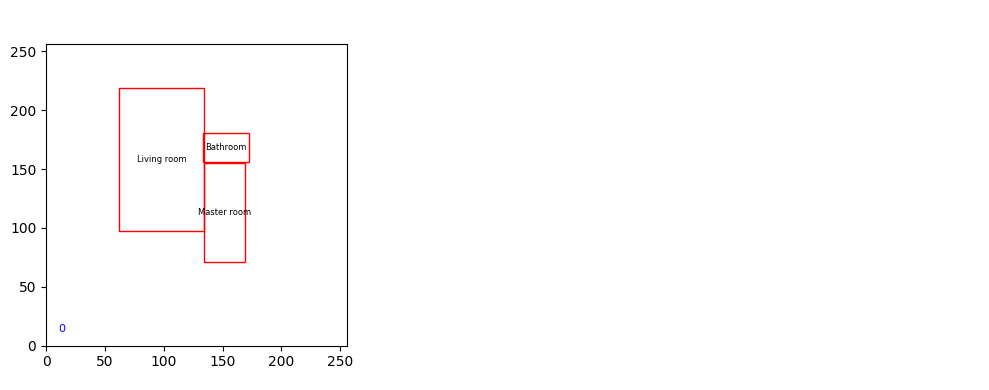

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle

# Original rectangles
with open('rectangles.pkl', 'rb') as f:
    rectangles = pickle.load(f)
#rectangles = [(64, 89, 143, 163), (59, 19, 145, 89), (60, 18, 86, 53), (84, 3, 146, 19), (143, 89, 201, 143), (142, 142, 183, 163), (35, 87, 63, 116)]
rectangles = [[x, 255 - y1, x2, 255 - y2] for x, y1, x2, y2 in rectangles]
orientation=ret_comb()
suggestions=False
combinations,d,predicted_vastu_categories=fn(rectangles,orientation,suggestions)
print(predicted_vastu_categories)
score=ret_vastu_score(predicted_vastu_categories)
print("Vastu Compliance Score:", score)
#print(combinations)
labels_list=[]
#scores_list=[]
if suggestions:
    for i in range(len(combinations)):
        predicted_room_categories = [MOD_ROOM_CLASS[idx.item()] for idx in np.array(combinations[i][0])]
        labels_list.append(predicted_room_categories)
        num_plots = len(combinations)
else:
    predicted_room_categories = [MOD_ROOM_CLASS[idx.item()] for idx in combinations]
    labels_list.append(predicted_room_categories)
    num_plots=1
        
# for i in range(cnt):
#     predicted_room_categories = [MOD_ROOM_CLASS[idx.item()] for idx in res_comb]
#     labels_list.append(predicted_room_categories)
    #scores_list.append(combinations[i][1])
#print(labels_list)

# Calculate number of rows and columns

cols = 3  # Number of columns
rows = -(-num_plots // cols)  # Ceiling division to ensure we have enough rows

fig, axs = plt.subplots(rows, cols, figsize=(10, 4*rows))
axs = axs.flatten()  # Flatten the 2D array of axes for easier indexing
j=0
for ax, labels in zip(axs, labels_list):
    # Set limits
    ax.set_xlim(0, 256)
    ax.set_ylim(0, 256)
    
    # Add rectangles to the plot
    for rect, label in zip(rectangles, labels):
        ax.add_patch(patches.Rectangle((rect[0], rect[1]), rect[2]-rect[0], rect[3]-rect[1], linewidth=1, edgecolor='r', facecolor='none'))
        # Calculate center coordinates of the rectangle
        center_x = (rect[0] + rect[2]) / 2
        center_y = (rect[1] + rect[3]) / 2
        # Add label at the center
        ax.text(center_x, center_y, label, fontsize=6, color='black', ha='center', va='center')  # Center the text
    ax.text(10, 10, f'{j}', fontsize=8, color='blue', ha='left', va='bottom')
    j+=1

    ax.set_aspect('equal')

# Hide any empty subplots
for i in range(num_plots, len(axs)):
    axs[i].axis('off')

plt.tight_layout()
# Display the plot
plt.show()

In [80]:
import math
(center_x,center_y)=center_of_plot(rectangles)
orientation=[]
#vastu=[]
result=[]
index=2
for i in range(len(rectangles)):
    # Calculate centroid
    x0,y0,x1,y1=rectangles[i]
    y_centroid = (y0 + y1) / 2
    x_centroid = (x0 + x1) / 2
    #print(x_centroid,y_centroid)

    deltaX = x_centroid - center_x
    deltaY = y_centroid - center_y

    degrees_temp = math.atan2(deltaX, deltaY)/math.pi*180

    if degrees_temp < 0:
        degrees_final = 360 + degrees_temp
    else:
        degrees_final = degrees_temp
    
    compass_brackets = ["N", "NE", "E", "SE", "S", "SW", "W", "NW", "N"]
    compass_lookup = round(degrees_final / 45)
    orientation.append(compass_lookup)
    #orientation.append(compass_brackets[compass_lookup])
    #vastu.append(vastu_scores[c][compass_lookup])
    room_types=combinations[index][0]
    result.append([room_types[i],compass_lookup])
print(result)

[[0, 0], [2, 7], [3, 7], [1, 5], [7, 4], [1, 3]]


In [81]:
data = torch.tensor(result, dtype=torch.float)
data

tensor([[0., 0.],
        [2., 7.],
        [3., 7.],
        [1., 5.],
        [7., 4.],
        [1., 3.]])

In [82]:
class Model1(torch.nn.Module):

    def __init__(self, layer_type, n_hidden=2):
        super(Model1, self).__init__()
        torch.manual_seed(42)
        self.is_mlp = True if layer_type.__name__=='Linear' else False
        self.layer1 = layer_type(2, 16)
        self.layer2 = torch.nn.ModuleList()
        for _ in range(n_hidden-1):
            self.layer2.append(layer_type(16,16))
        self.classifier = Linear(16, 8)

    def forward(self, x, edge_index):
        h = self.layer1(x) if self.is_mlp else self.layer1(x, edge_index)
        h = F.relu(h)
        for layer in self.layer2:
            h = layer(h) if self.is_mlp else layer(h, edge_index)
            h = F.relu(h)
        out = self.classifier(h)
        return out

In [83]:
loaded_model = Model1(layer_type=Linear, n_hidden=2)
loaded_model.load_state_dict(torch.load('MLP_vastu_trained_model.pth',map_location=torch.device('cpu')))
loaded_model

Model1(
  (layer1): Linear(in_features=2, out_features=16, bias=True)
  (layer2): ModuleList(
    (0): Linear(in_features=16, out_features=16, bias=True)
  )
  (classifier): Linear(in_features=16, out_features=8, bias=True)
)

In [84]:
with torch.no_grad():
    x, edge_index = data, d.edge_index
    new_predictions = loaded_model(x, _)
predicted_categories = new_predictions.argmax(dim=1)
print(predicted_categories)
total_sum = torch.sum(predicted_categories).item()
max_possible_sum = 7 * len(predicted_categories)
score = (total_sum / max_possible_sum) * 100

print("Vastu Compliance Score:", score)

tensor([7, 6, 7, 7, 2, 1])
Vastu Compliance Score: 71.42857142857143
